In [ ]:
!pip install shap lime scikit-learn tensorflow evidently Fairlearn

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay)

import shap
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity


import evidently

from evidently import ColumnMapping

from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset, RegressionPreset
from evidently.metrics import *

from evidently.test_suite import TestSuite
from evidently.tests.base_test import generate_column_tests
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset, RegressionTestPreset
from evidently.tests import *

from IPython import display
from datetime import date

pd.set_option("display.float_format", "{:.2f}".format)
sns.set()

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 887.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.1/231.1 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.5/555.5 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.1/442.1 kB 8.8 MB/s eta 0:00:00
 

## Load the dataset


We'll start by loading the dataset:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# https://github.com/Yashas-153/Data-Science-Stem-Salaries/blob/main/Data_science_Stem_EDA.ipynb
df = pd.read_csv("/content/drive/MyDrive/Levels_Fyi_Salary_Data.csv")

In [ ]:
df.head()

timestamp    company level                         title  \
0   6/7/2017 11:33:27     Oracle    L3               Product Manager   
1  6/10/2017 17:11:29       eBay  SE 2             Software Engineer   
2  6/11/2017 14:53:57     Amazon    L7               Product Manager   
3   6/17/2017 0:23:14      Apple    M1  Software Engineering Manager   
4  6/20/2017 10:58:51  Microsoft    60             Software Engineer   

   totalyearlycompensation           location  yearsofexperience  \
0                   127000   Redwood City, CA               1.50   
1                   100000  San Francisco, CA               5.00   
2                   310000        Seattle, WA               8.00   
3                   372000      Sunnyvale, CA               7.00   
4                   157000  Mountain View, CA               5.00   

   yearsatcompany  tag  basesalary  stockgrantvalue    bonus gender  \
0            1.50  NaN   107000.00         20000.00 10000.00    NaN   
1            3.00  NaN        0.00             0.00     0.00    NaN   
2            0.00  NaN   155000.00             0.00     0.00    NaN   
3            5.00  NaN   157000.00        180000.00 35000.00    NaN   
4            3.00  NaN        0.00             0.00     0.00    NaN   

  otherdetails  cityid  dmaid  rowNumber  Masters_Degree  Bachelors_Degree  \
0          NaN    7392 807.00          1               0                 0   
1          NaN    7419 807.00          2               0                 0   
2          NaN   11527 819.00          3               0                 0   
3          NaN    7472 807.00          7               0                 0   
4          NaN    7322 807.00          9               0                 0   

   Doctorate_Degree  Highschool  Some_College  Race_Asian  Race_White  \
0                 0           0             0           0           0   
1                 0           0             0           0           0   
2                 0           0             0           0           0   
3                 0           0             0           0           0   
4                 0           0             0           0           0   

   Race_Two_Or_More  Race_Black  Race_Hispanic Race Education  
0                 0           0              0  NaN       NaN  
1                 0           0              0  NaN       NaN  
2                 0           0              0  NaN       NaN  
3                 0           0              0  NaN       NaN  
4                 0           0              0  NaN       NaN

## EDA

In [ ]:
# check the shape
df.shape

(62642, 29)

In [ ]:
# get info about nulls and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62642 entries, 0 to 62641
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                62642 non-null  object 
 1   company                  62637 non-null  object 
 2   level                    62519 non-null  object 
 3   title                    62642 non-null  object 
 4   totalyearlycompensation  62642 non-null  int64  
 5   location                 62642 non-null  object 
 6   yearsofexperience        62642 non-null  float64
 7   yearsatcompany           62642 non-null  float64
 8   tag                      61772 non-null  object 
 9   basesalary               62642 non-null  float64
 10  stockgrantvalue          62642 non-null  float64
 11  bonus                    62642 non-null  float64
 12  gender                   43102 non-null  object 
 13  otherdetails             40134 non-null  object 
 14  cityid                

In [ ]:
# get info about nulls
df.isna().sum()

timestamp                      0
company                        5
level                        123
title                          0
totalyearlycompensation        0
location                       0
yearsofexperience              0
yearsatcompany                 0
tag                          870
basesalary                     0
stockgrantvalue                0
bonus                          0
gender                     19540
otherdetails               22508
cityid                         0
dmaid                          2
rowNumber                      0
Masters_Degree                 0
Bachelors_Degree               0
Doctorate_Degree               0
Highschool                     0
Some_College                   0
Race_Asian                     0
Race_White                     0
Race_Two_Or_More               0
Race_Black                     0
Race_Hispanic                  0
Race                       40215
Education                  32272
dtype: int64

In [ ]:
# drop NAs
df = df.dropna()
df.shape

(21515, 29)

In [ ]:
# drop duplicates
df = df.drop_duplicates()
df.shape

(21515, 29)

In [ ]:
df.head()

timestamp    company level              title  \
15710  1/27/2020 22:59:06     Google    L6  Software Engineer   
23532   7/3/2020 19:56:38  Microsoft    61  Software Engineer   
23533   7/3/2020 20:03:57     Google    L5  Software Engineer   
23534   7/3/2020 20:05:37  Microsoft    62  Software Engineer   
23535   7/3/2020 20:19:06      Blend   IC3  Software Engineer   

       totalyearlycompensation           location  yearsofexperience  \
15710                   400000      Sunnyvale, CA               5.00   
23532                   136000        Redmond, WA               3.00   
23533                   337000      San Bruno, CA               6.00   
23534                   222000        Seattle, WA               4.00   
23535                   187000  San Francisco, CA               5.00   

       yearsatcompany                             tag  basesalary  \
15710            5.00  Distributed Systems (Back-End)   210000.00   
23532            2.00                          DevOps   124000.00   
23533            6.00                      Full Stack   177000.00   
23534            4.00      API Development (Back-End)   164000.00   
23535            0.00                      Full Stack   165000.00   

       stockgrantvalue    bonus gender  \
15710        145000.00 45000.00   Male   
23532          1000.00 11000.00   Male   
23533        125000.00 36000.00   Male   
23534         38000.00 20000.00   Male   
23535         22000.00     0.00   Male   

                                            otherdetails  cityid  dmaid  \
15710                                        Asian - PhD    7472 807.00   
23532  Race: Two or More Races, Academic Level: Bache...   11521 819.00   
23533     Race: Asian, Academic Level: Bachelor’s degree    7413 807.00   
23534       Race: Asian, Academic Level: Master’s degree   11527 819.00   
23535     Race: White, Academic Level: Bachelor’s degree    7419 807.00   

       rowNumber  Masters_Degree  Bachelors_Degree  Doctorate_Degree  \
15710      21208               0                 0                 1   
23532      32237               0                 1                 0   
23533      32239               0                 1                 0   
23534      32240               1                 0                 0   
23535      32241               0                 1                 0   

       Highschool  Some_College  Race_Asian  Race_White  Race_Two_Or_More  \
15710           0             0           1           0                 0   
23532           0             0           0           0                 1   
23533           0             0           1           0                 0   
23534           0             0           1           0                 0   
23535           0             0           0           1                 0   

       Race_Black  Race_Hispanic         Race          Education  
15710           0              0        Asian                PhD  
23532           0              0  Two Or More  Bachelor's Degree  
23533           0              0        Asian  Bachelor's Degree  
23534           0              0        Asian    Master's Degree  
23535           0              0        White  Bachelor's Degree

In [ ]:
# numerical fearures
num_feats = ['totalyearlycompensation', 'yearsofexperience', 'yearsatcompany', 'basesalary', 'stockgrantvalue', 'bonus']
# categorical (binary)
bin_feats = ['gender']
# caterorical (multi-)
multi_feats= ['company', 'level', 'location', 'Race', 'Education']
cat_feats = bin_feats + multi_feats

In [ ]:
# get overview of ranges and basic stats of numeric variables
df[num_feats].describe().T

count      mean       std      min       25%  \
totalyearlycompensation 21515.00 197950.78 133131.31 10000.00 119000.00   
yearsofexperience       21515.00      7.13      5.85     0.00      3.00   
yearsatcompany          21515.00      2.71      3.33     0.00      0.00   
basesalary              21515.00 133894.54  57231.65  4000.00 100000.00   
stockgrantvalue         21515.00  44974.39  72523.73     0.00      0.00   
bonus                   21515.00  18401.30  24802.56     0.00   3000.00   

                              50%       75%        max  
totalyearlycompensation 174000.00 245000.00 4980000.00  
yearsofexperience            6.00     10.00      45.00  
yearsatcompany               2.00      4.00      40.00  
basesalary              135000.00 165000.00  900000.00  
stockgrantvalue          20000.00  55000.00  954000.00  
bonus                    13000.00  25000.00  900000.00

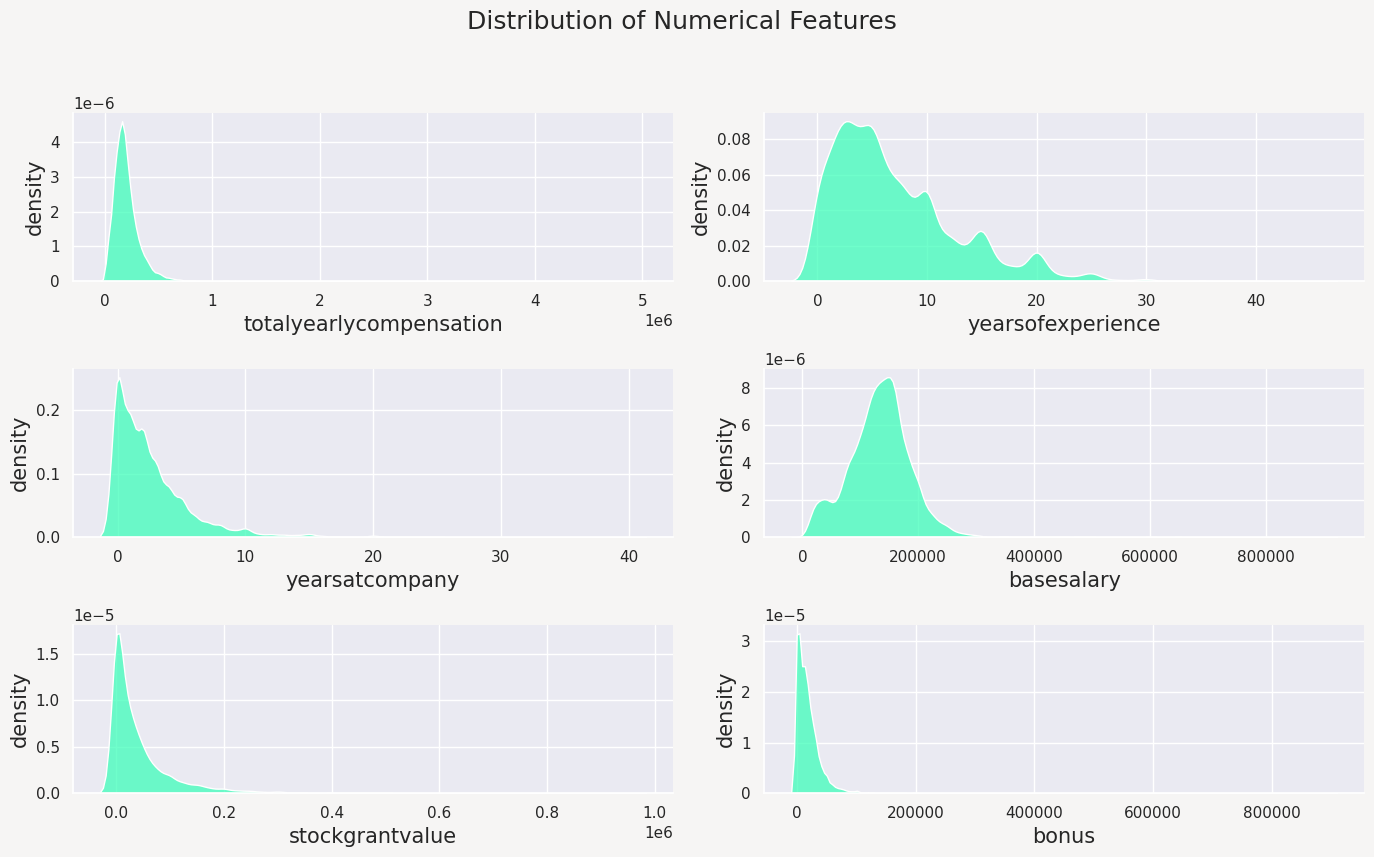

In [ ]:
# explore numerical features distirubtion
import seaborn as sns

mypal= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA']

L = len(num_feats)
ncol = 2
nrow = int(np.ceil(L / ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(14, 9), facecolor='#F6F5F4')
fig.subplots_adjust(top=0.92)

# use enumerate to get both the index and the feature name
for i, col in enumerate(num_feats):
    # determine the position of the subplot
    row_idx = i // ncol
    col_idx = i % ncol
    # color = mypal[i % len(mypal)]
    # create the kdeplot on the correct subplot axis
    ax = sns.kdeplot(data=df, x=col, multiple="stack", color='#3FFEBA', ax=axes[row_idx, col_idx])
    ax.set_xlabel(col, fontsize=15)
    ax.set_ylabel("density", fontsize=15)
    sns.despine(right=True)

# title
plt.suptitle('Distribution of Numerical Features', fontsize=18)

# adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

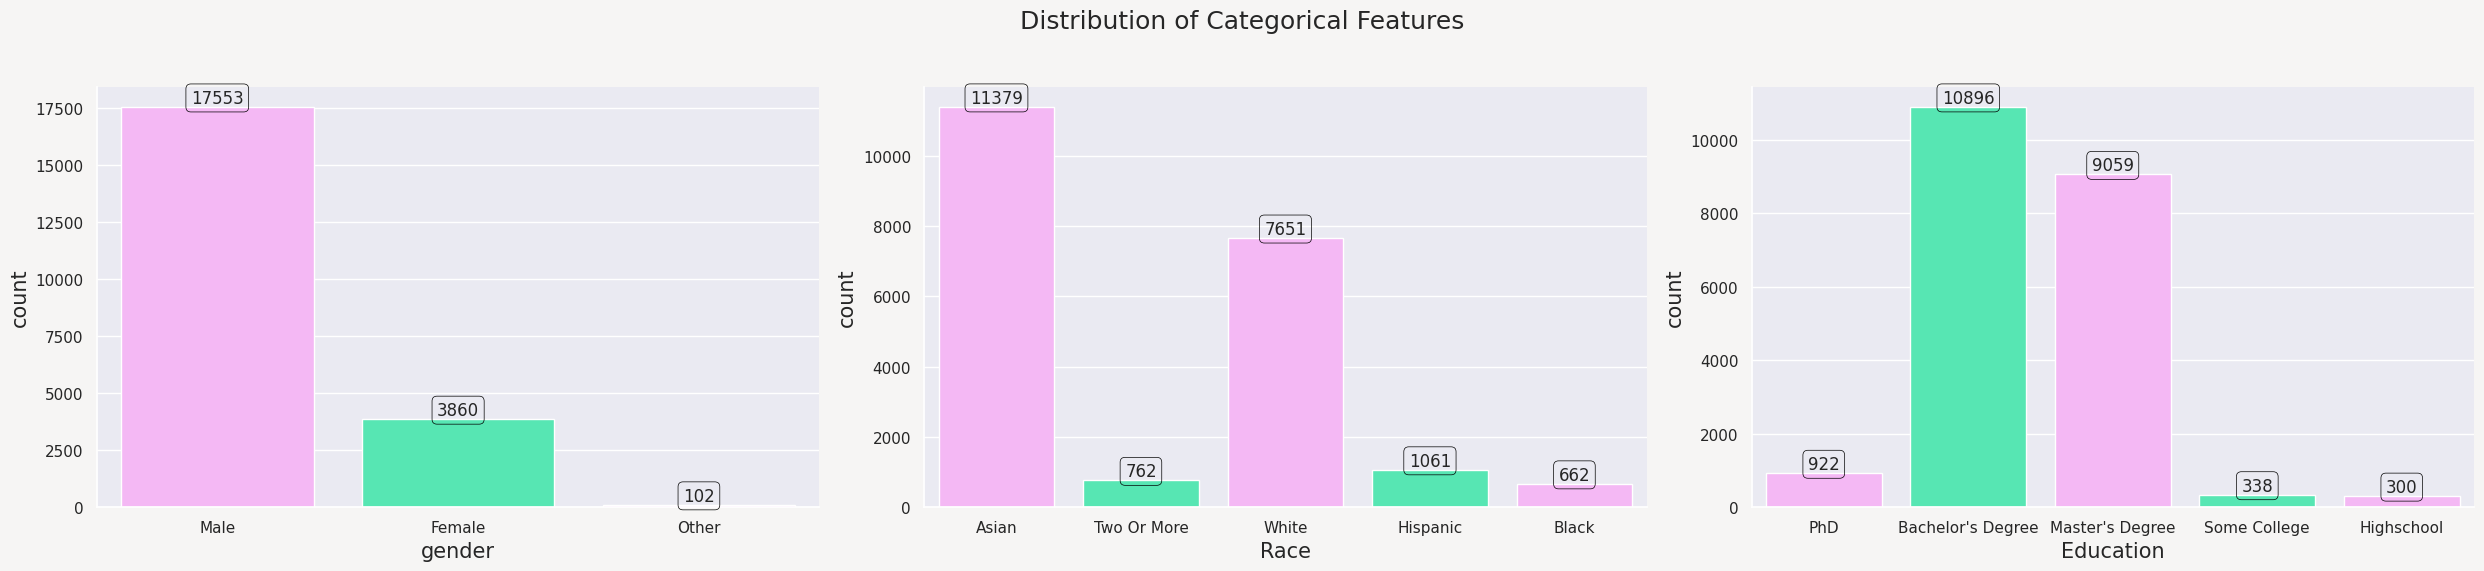

In [ ]:
# explore categorical features distribution
cat_feats2= ['gender', 'Race', 'Education']

def count_plot(data, cat_feats):
    L = len(cat_feats)
    ncol = 3
    nrow = int(np.ceil(L / ncol))

    fig, axes = plt.subplots(nrow, ncol, figsize=(25, 6), facecolor='#F6F5F4')
    fig.subplots_adjust(top=0.92)

    # for easy looping
    axes = axes.flatten()

    for i, col in enumerate(cat_feats):
        ax = sns.countplot(data=data, x=col, palette=mypal[1::4], ax=axes[i])
        ax.set_xlabel(col, fontsize=15)
        ax.set_ylabel("count", fontsize=15)
        sns.despine(right=True)

        # Add annotations to each bar
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.0f}'.format(height if height > 0 else 0),
                    ha="center", va='bottom',
                    bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

    plt.suptitle('Distribution of Categorical Features', fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

count_plot(df, cat_feats2)

In [ ]:
# for the sake of our project we will consider only male/female
df = df[df['gender'] != 'Other']
df['gender'].value_counts()

gender
Male      17553
Female     3860
Name: count, dtype: int64

In [ ]:
# explore correlation between target variable and numerical features
corr_matrix = df.corr(numeric_only=True)
corr_matrix

totalyearlycompensation  yearsofexperience  \
totalyearlycompensation                     1.00               0.40   
yearsofexperience                           0.40               1.00   
yearsatcompany                              0.17               0.54   
basesalary                                  0.79               0.42   
stockgrantvalue                             0.79               0.29   
bonus                                       0.54               0.29   
cityid                                     -0.11              -0.01   
dmaid                                       0.41               0.04   
rowNumber                                  -0.03              -0.00   
Masters_Degree                              0.10               0.10   
Bachelors_Degree                           -0.15              -0.12   
Doctorate_Degree                            0.14              -0.00   
Highschool                                 -0.01               0.02   
Some_College                                0.01               0.07   
Race_Asian                                 -0.04              -0.10   
Race_White                                  0.05               0.13   
Race_Two_Or_More                            0.01              -0.02   
Race_Black                                 -0.02              -0.04   
Race_Hispanic                              -0.01               0.00   

                         yearsatcompany  basesalary  stockgrantvalue  bonus  \
totalyearlycompensation            0.17        0.79             0.79   0.54   
yearsofexperience                  0.54        0.42             0.29   0.29   
yearsatcompany                     1.00        0.18             0.11   0.14   
basesalary                         0.18        1.00             0.48   0.42   
stockgrantvalue                    0.11        0.48             1.00   0.27   
bonus                              0.14        0.42             0.27   1.00   
cityid                             0.00       -0.15            -0.07  -0.04   
dmaid                              0.06        0.55             0.25   0.18   
rowNumber                         -0.01       -0.05            -0.01  -0.04   
Masters_Degree                     0.04        0.12             0.05   0.07   
Bachelors_Degree                  -0.04       -0.18            -0.10  -0.10   
Doctorate_Degree                   0.01        0.14             0.12   0.10   
Highschool                        -0.01       -0.01            -0.01  -0.01   
Some_College                       0.01        0.02             0.01   0.00   
Race_Asian                        -0.06       -0.08            -0.00  -0.01   
Race_White                         0.09        0.08             0.02   0.02   
Race_Two_Or_More                  -0.02        0.01             0.00   0.00   
Race_Black                        -0.05       -0.01            -0.04   0.00   
Race_Hispanic                     -0.01       -0.00            -0.02  -0.00   

                         cityid  dmaid  rowNumber  Masters_Degree  \
totalyearlycompensation   -0.11   0.41      -0.03            0.10   
yearsofexperience         -0.01   0.04      -0.00            0.10   
yearsatcompany             0.00   0.06      -0.01            0.04   
basesalary                -0.15   0.55      -0.05            0.12   
stockgrantvalue           -0.07   0.25      -0.01            0.05   
bonus                     -0.04   0.18      -0.04            0.07   
cityid                     1.00  -0.11       0.02           -0.03   
dmaid                     -0.11   1.00      -0.11            0.10   
rowNumber                  0.02  -0.11       1.00            0.02   
Masters_Degree            -0.03   0.10       0.02            1.00   
Bachelors_Degree           0.05  -0.12      -0.01           -0.86   
Doctorate_Degree          -0.02   0.07      -0.02           -0.18   
Highschool                -0.02  -0.04       0.00           -0.10   
Some_College              -0.01   0.01      -0.01        

Text(0.5, 1.05, "Numerical features correlation (Pearson's)")

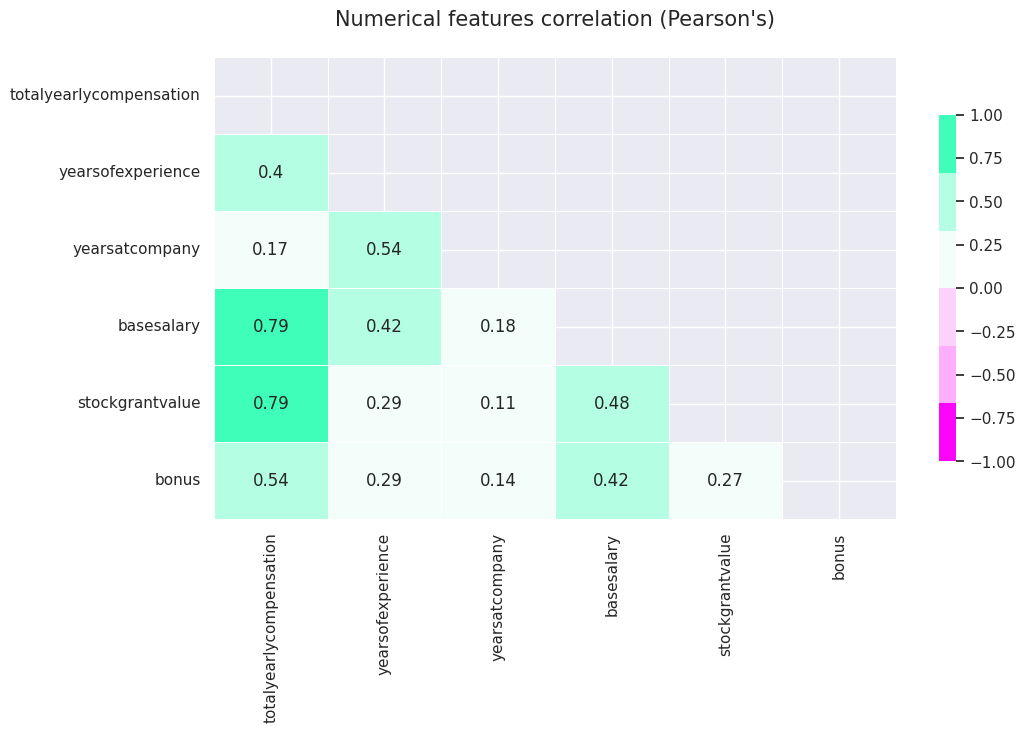

In [ ]:
df_ = df[num_feats]
corr = df_.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 6), facecolor=None)
cmap = sns.color_palette(mypal, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Numerical features correlation (Pearson's)", fontsize=15, y= 1.05)

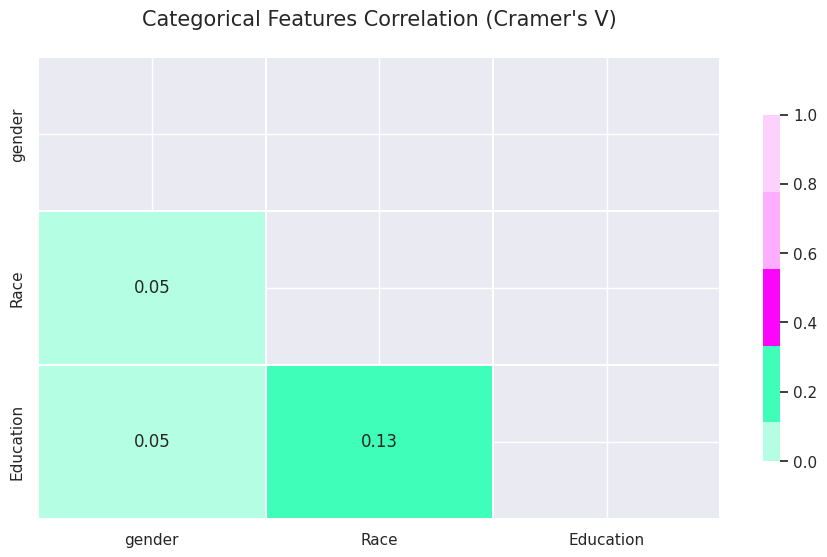

In [ ]:
from scipy import stats

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# calculate the correlation coefficients using the above function
data_ = df[cat_feats2]
rows= []
for x in data_:
    col = []
    for y in data_ :
        cramers =cramers_v(data_[x], data_[y])
        col.append(round(cramers,2))
    rows.append(col)

cramers_results = np.array(rows)
df__ = pd.DataFrame(cramers_results, columns = data_.columns, index = data_.columns)

# color palette
mypal_1= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA', '#FC05FB', '#FEAEFE', '#FCD2FC']
# plot the heat map
mask = np.triu(np.ones_like(df__, dtype=bool))
corr = df__.mask(mask)
f, ax = plt.subplots(figsize=(11, 6), facecolor=None)
cmap = sns.color_palette(mypal_1, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=0, center=0, annot=True,
            square=False, linewidths=.01, cbar_kws={"shrink": 0.75})
ax.set_title("Categorical Features Correlation (Cramer's V)", fontsize=15, y= 1.05);

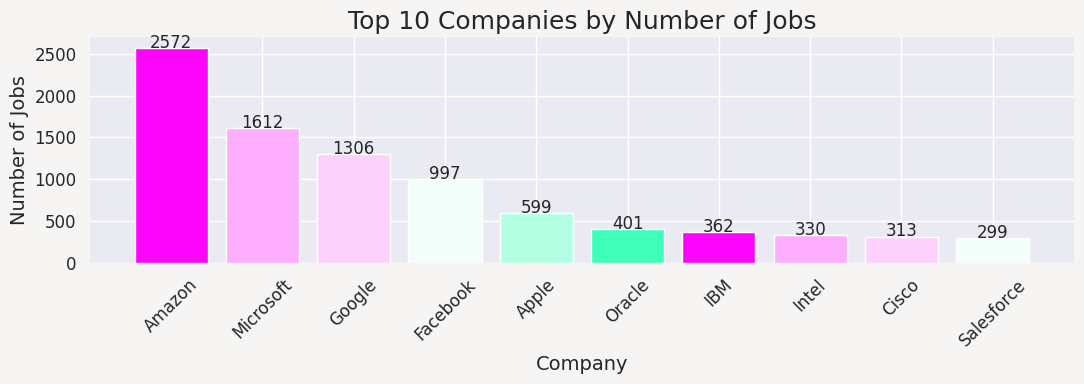

In [ ]:
# Extract top 10 companies by job counts
top_companies = df["company"].value_counts().head(10)

# Create the bar plot
plt.figure(figsize=(11, 4), facecolor='#F6F5F4')
bars = plt.bar(top_companies.index, top_companies.values, color=mypal[:len(top_companies)])

# Add hover-like labels for the bar values
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{int(bar.get_height())}",
        ha='center',
        fontsize=12,
        # color='black'
    )

# Set axis labels and title
plt.xlabel("Company", fontsize=14)
plt.ylabel("Number of Jobs", fontsize=14)
plt.title("Top 10 Companies by Number of Jobs", fontsize=18)

# Style adjustments
sns.despine(left=True, bottom=True)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
df["title"].value_counts()

title
Software Engineer               13596
Product Manager                  1442
Software Engineering Manager     1014
Data Scientist                    867
Hardware Engineer                 778
Technical Program Manager         631
Product Designer                  593
Management Consultant             449
Business Analyst                  436
Solution Architect                409
Marketing                         354
Mechanical Engineer               252
Sales                             217
Recruiter                         212
Human Resources                   163
Name: count, dtype: int64

In [ ]:
# # we will focus only on tech industry

# exclude_values = ['Marketing', 'Mechanical Engineer', 'Sales', 'Recruiter', 'Human Resources']
# df = df[~df['title'].isin(exclude_values)]
# df["title"].value_counts()

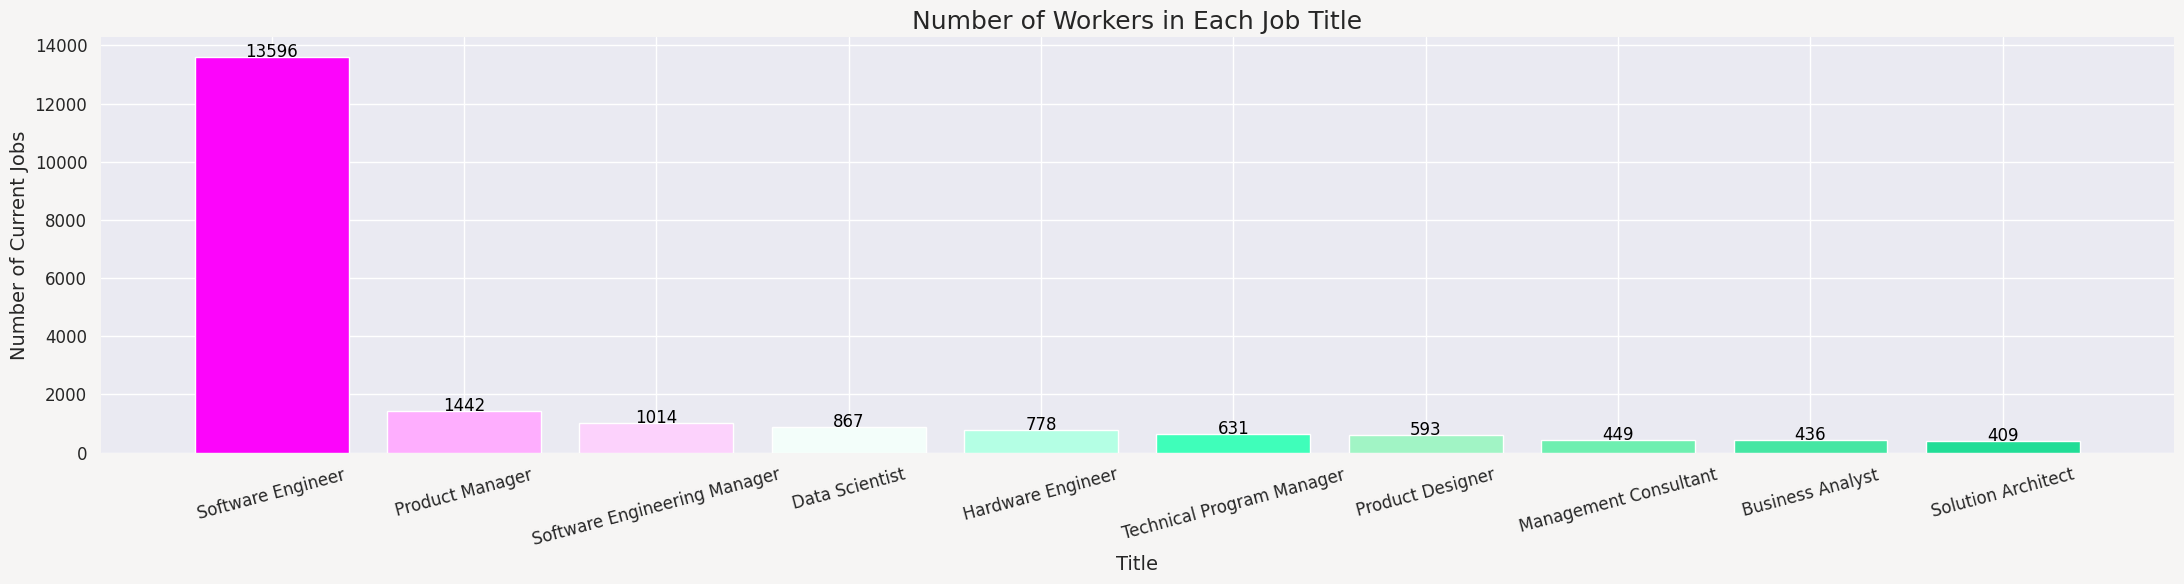

In [ ]:
top_comp = df["title"].value_counts()

# Custom palette (adapted to match the previous style)
mypal = ['#FC05FB', '#FEAEFE', '#FCD2FC', '#F3FEFA', '#B4FFE4', '#3FFEBA', '#A1F4C5', '#6EEFB0', '#45E6A3', '#21DD96']

# Create the bar plot
plt.figure(figsize=(22, 6), facecolor='#F6F5F4')
bars = plt.bar(top_comp.index[:10], top_comp.values[:10], color=mypal[:10])

# Add hover-like labels for the bar values
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{int(bar.get_height())}",
        ha='center',
        fontsize=12,
        color='black'
    )

# Set axis labels and title
plt.xlabel("Title", fontsize=14)
plt.ylabel("Number of Current Jobs", fontsize=14)
plt.title("Number of Workers in Each Job Title", fontsize=18)

# Style adjustments
sns.despine(left=True, bottom=True)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

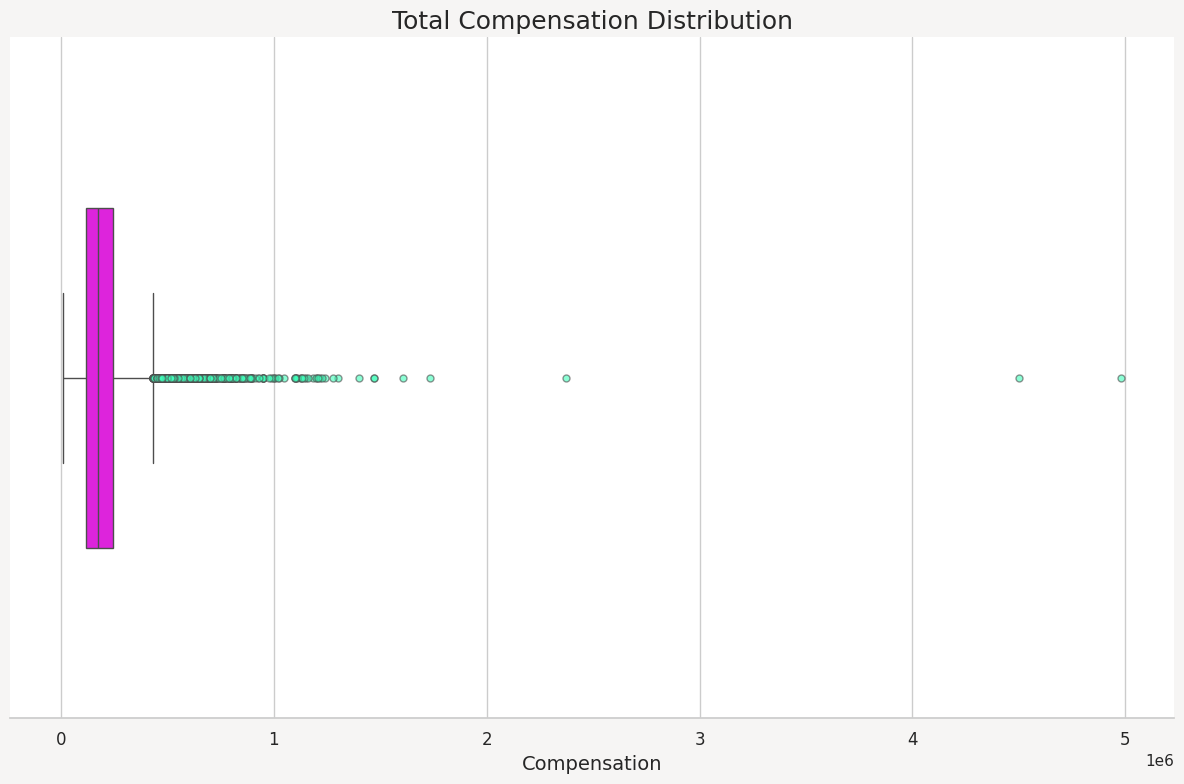

In [ ]:
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(12, 8), facecolor='#F6F5F4')

# Custom color palette
mypal = ['#FC05FB', '#FEAEFE', '#FCD2FC', '#F3FEFA', '#B4FFE4', '#3FFEBA']
color = mypal[0]  # Choose a primary color for the boxplot

# Plot the boxplot
sns.boxplot(
    data=df,
    x="totalyearlycompensation",
    color=color,
    width=0.5,
    flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': '#3FFEBA', 'alpha': 0.6}
)

# Set title and labels
plt.title("Total Compensation Distribution", fontsize=18)
plt.xlabel("Compensation", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Style adjustments
sns.despine(left=True)
plt.tight_layout()
9
# Show the plot
plt.show()

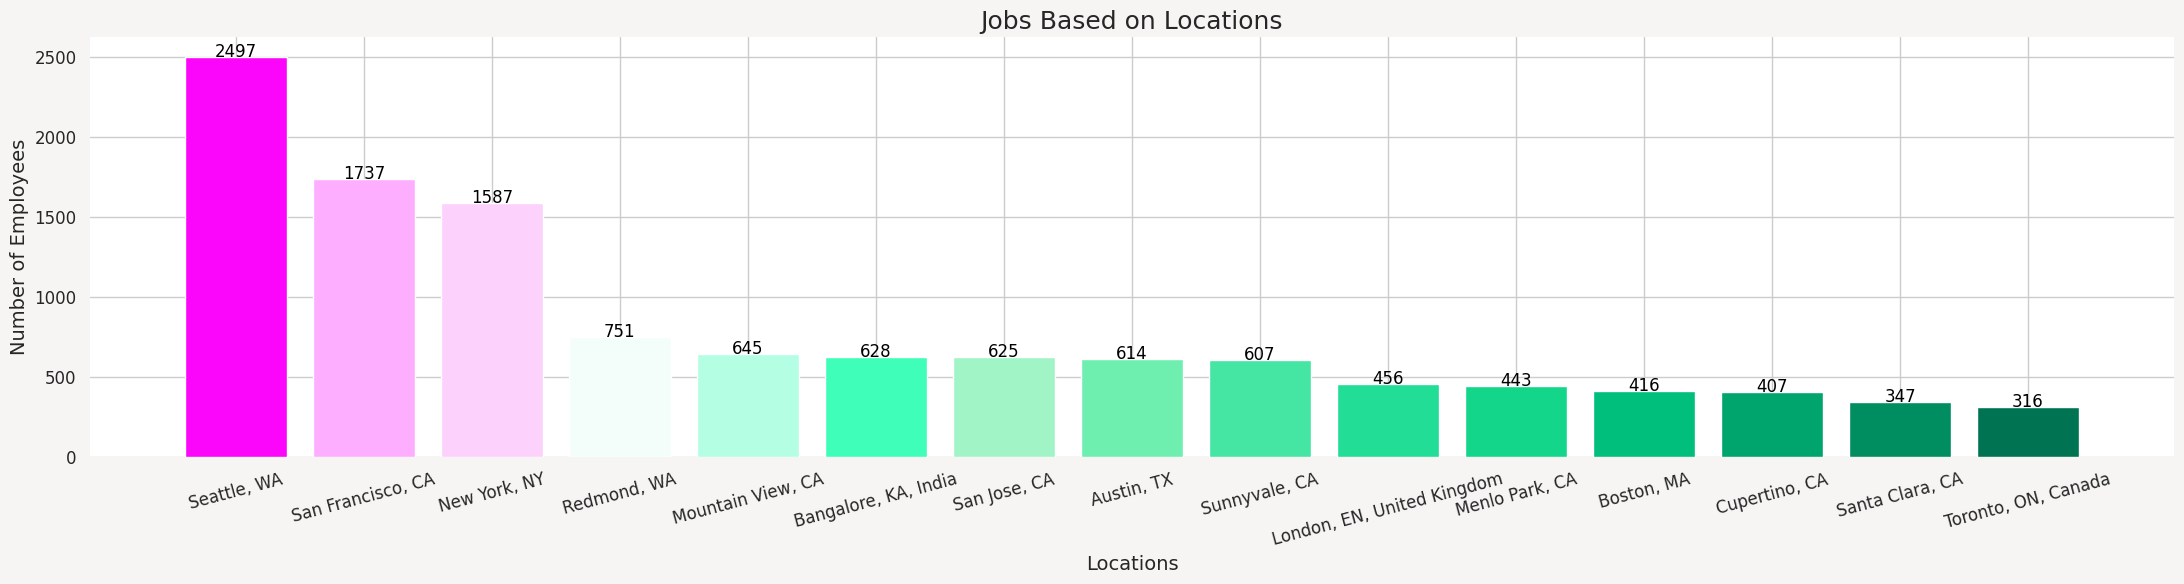

In [ ]:
# Extract the top 15 locations and their counts
loctn = df["location"].value_counts().head(15)

# Custom palette (adapted for this chart)
mypal = ['#FC05FB', '#FEAEFE', '#FCD2FC', '#F3FEFA', '#B4FFE4', '#3FFEBA', '#A1F4C5', '#6EEFB0', '#45E6A3', '#21DD96', '#13D68A', '#00BE7C', '#00A56E', '#008D60', '#007452']

# Create the bar plot
plt.figure(figsize=(22, 6), facecolor='#F6F5F4')
bars = plt.bar(loctn.index, loctn.values, color=mypal[:len(loctn)])

# Add hover-like labels for the bar values
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f"{int(bar.get_height())}",
        ha='center',
        fontsize=12,
        color='black'
    )

# Set axis labels and title
plt.xlabel("Locations", fontsize=14)
plt.ylabel("Number of Employees", fontsize=14)
plt.title("Jobs Based on Locations", fontsize=18)

# Style adjustments
sns.despine(left=True, bottom=True)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# df['level'].value_counts()

In [ ]:
# df["location"].value_counts()

In [ ]:
# let's ensure the comparability and choose only USA for our analysis

df['location_state'] = df['location'].str[-2:]

pd.set_option('display.max_rows', None)
df["location_state"].value_counts()

location_state
CA    6470
WA    3528
ia    1791
NY    1652
TX    1137
da     773
MA     603
om     526
VA     387
IL     344
ny     267
OR     259
GA     254
nd     246
an     221
DC     219
NC     215
CO     200
PA     185
AZ     152
re     148
NJ     143
MN     127
el     123
FL     117
MI     103
ds      95
MO      89
UT      89
OH      83
na      56
IN      49
MD      48
WI      46
in      46
ne      44
TN      40
AR      38
CT      38
ce      34
il      29
DE      28
ic      27
KS      24
en      24
R)      19
LA      16
AL      15
rg      14
us      13
es      13
ID      13
ay      12
KY      12
ca      12
NV      12
IA      12
co      11
NE      11
th      11
SC      10
ly       9
NH       9
RI       9
ry       8
OK       8
MT       5
NM       5
WV       4
rk       4
le       4
al       3
ru       3
ya       3
VT       2
MS       2
ME       2
HI       2
ND       2
WY       1
um       1
va       1
ar       1
am       1
pt       1
Name: count, dtype: int64

In [ ]:
# filtering
us_states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

df['location_last_2'] = df['location'].str[-2:]
df_filtered = df[df['location_last_2'].isin(us_states)]

In [ ]:
# print(df_filtered["location_state"].value_counts())
df_filtered["location_state"].nunique()

48

In [ ]:
# mapping state to region

state_to_region = {
    'AL': 'South', 'AK': 'West', 'AZ': 'West', 'AR': 'South', 'CA': 'West',
    'CO': 'West', 'CT': 'Northeast', 'DE': 'South', 'FL': 'South', 'GA': 'South',
    'HI': 'West', 'ID': 'West', 'IL': 'Midwest', 'IN': 'Midwest', 'IA': 'Midwest',
    'KS': 'Midwest', 'KY': 'South', 'LA': 'South', 'ME': 'Northeast', 'MD': 'South',
    'MA': 'Northeast', 'MI': 'Midwest', 'MN': 'Midwest', 'MS': 'South', 'MO': 'Midwest',
    'MT': 'West', 'NE': 'Midwest', 'NV': 'West', 'NH': 'Northeast', 'NJ': 'Northeast',
    'NM': 'West', 'NY': 'Northeast', 'NC': 'South', 'ND': 'Midwest', 'OH': 'Midwest',
    'OK': 'South', 'OR': 'West', 'PA': 'Northeast', 'RI': 'Northeast', 'SC': 'South',
    'SD': 'Midwest', 'TN': 'South', 'TX': 'South', 'UT': 'West', 'VT': 'Northeast',
    'VA': 'South', 'WA': 'West', 'WV': 'South', 'WI': 'Midwest', 'WY': 'West', 'DC': 'South'
}
df_filtered['region'] = df_filtered['location_state'].map(state_to_region)

In [ ]:
df_filtered.head()

timestamp    company level              title  \
15710  1/27/2020 22:59:06     Google    L6  Software Engineer   
23532   7/3/2020 19:56:38  Microsoft    61  Software Engineer   
23533   7/3/2020 20:03:57     Google    L5  Software Engineer   
23534   7/3/2020 20:05:37  Microsoft    62  Software Engineer   
23535   7/3/2020 20:19:06      Blend   IC3  Software Engineer   

       totalyearlycompensation           location  yearsofexperience  \
15710                   400000      Sunnyvale, CA               5.00   
23532                   136000        Redmond, WA               3.00   
23533                   337000      San Bruno, CA               6.00   
23534                   222000        Seattle, WA               4.00   
23535                   187000  San Francisco, CA               5.00   

       yearsatcompany                             tag  basesalary  \
15710            5.00  Distributed Systems (Back-End)   210000.00   
23532            2.00                          DevOps   124000.00   
23533            6.00                      Full Stack   177000.00   
23534            4.00      API Development (Back-End)   164000.00   
23535            0.00                      Full Stack   165000.00   

       stockgrantvalue    bonus gender  \
15710        145000.00 45000.00   Male   
23532          1000.00 11000.00   Male   
23533        125000.00 36000.00   Male   
23534         38000.00 20000.00   Male   
23535         22000.00     0.00   Male   

                                            otherdetails  cityid  dmaid  \
15710                                        Asian - PhD    7472 807.00   
23532  Race: Two or More Races, Academic Level: Bache...   11521 819.00   
23533     Race: Asian, Academic Level: Bachelor’s degree    7413 807.00   
23534       Race: Asian, Academic Level: Master’s degree   11527 819.00   
23535     Race: White, Academic Level: Bachelor’s degree    7419 807.00   

       rowNumber  Masters_Degree  Bachelors_Degree  Doctorate_Degree  \
15710      21208               0                 0                 1   
23532      32237               0                 1                 0   
23533      32239               0                 1                 0   
23534      32240               1                 0                 0   
23535      32241               0                 1                 0   

       Highschool  Some_College  Race_Asian  Race_White  Race_Two_Or_More  \
15710           0             0           1           0                 0   
23532           0             0           0           0                 1   
23533           0             0           1           0                 0   
23534           0             0           1           0                 0   
23535           0             0           0           1                 0   

       Race_Black  Race_Hispanic         Race          Education  \
15710           0              0        Asian                PhD   
23532           0              0  Two Or More  Bachelor's Degree   
23533           0              0        Asian  Bachelor's Degree   
23534           0              0        Asian    Master's Degree   
23535           0              0        White  Bachelor's Degree   

      location_state location_last_2 region  
15710             CA              CA   West  
23532             WA              WA   West  
23533             CA              CA   West  
23534             WA              WA   West  
23535             CA              CA   West

In [ ]:
# group by year for data drift analysis

df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], errors='coerce')
df_filtered['year'] = df_filtered['timestamp'].dt.year

In [ ]:
unique_years = df_filtered['year'].dropna().unique()
unique_years.sort()
unique_years

array([2020, 2021], dtype=int32)

# Training the initial models

In [ ]:
key_columns = ['totalyearlycompensation', 'yearsofexperience', 'yearsatcompany',
               'gender', 'Race', 'Education', 'basesalary', 'bonus', 'stockgrantvalue', 'region', 'year']

# Filter to only relevant data
filtered_data = df_filtered[key_columns].copy()

In [ ]:
data_2021 = filtered_data[filtered_data['year'] == 2021]
data_2020 = filtered_data[filtered_data['year'] == 2020]

In [ ]:
# Apply log transformation to specified features
for column in ['totalyearlycompensation', 'basesalary', 'stockgrantvalue', 'bonus']:
    data_2020[column] = np.log1p(data_2020[column])

median_compensation = data_2020['totalyearlycompensation'].median()
data_2020['comp_above_median'] = (data_2020['totalyearlycompensation'] > median_compensation).astype(int)

In [ ]:
target_variable = "comp_above_median"
demographic = ["gender"]
sensitive = ["Race"]

In [ ]:
data_2020["comp_above_median"].value_counts(normalize=True)

comp_above_median
0   0.50
1   0.50
Name: proportion, dtype: float64

In [ ]:
data_2020["gender"].value_counts(normalize=True)

gender
Male     0.79
Female   0.21
Name: proportion, dtype: float64

In [ ]:
data_2020["Race"].value_counts(normalize=True)

Race
Asian         0.50
White         0.36
Hispanic      0.06
Black         0.04
Two Or More   0.04
Name: proportion, dtype: float64

In [ ]:
Y = data_2020.loc[:, target_variable]

In [ ]:
X = pd.get_dummies(data_2020.drop(columns=[
    "Race",
    'totalyearlycompensation',
    'comp_above_median',
    'year'
]))

In [ ]:
random_seed = 123

X_train, X_test, Y_train, Y_test, df_train, df_test = train_test_split(
    X,
    Y,
    data_2020,
    test_size=0.20,
    stratify=Y,
    random_state=random_seed
)

In [ ]:
pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("logistic_regression", LogisticRegression(max_iter=1000))
])

In [ ]:
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('logistic_regression', LogisticRegression(max_iter=1000))])

In [ ]:
Y_pred_proba = pipeline.predict_proba(X_test)[:,1]
Y_pred = pipeline.predict(X_test)

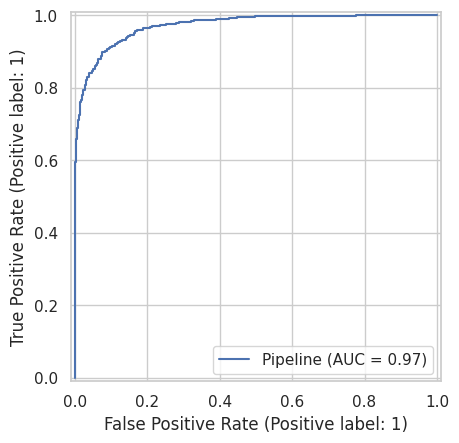

In [ ]:
RocCurveDisplay.from_estimator(pipeline, X_test, Y_test);

#Model Interpretability - LIME & SHAP

In [ ]:
pipeline.predict([X_test.iloc[2].values])[0]

0

In [ ]:
# Initialize LIME explainer with training data
explainer_lime_lr = LimeTabularExplainer(X_train.values,
                                      feature_names=X_train.columns,
                                      class_names=["Less than median","More than Median"],
                                      discretize_continuous=True)

# Generate LIME explanation for a single instance (e.g., third row in X_test)
lime_exp_lr = explainer_lime_lr.explain_instance(X_test.iloc[2].values, pipeline.predict_proba, num_features=20)

lime_exp_lr.show_in_notebook()

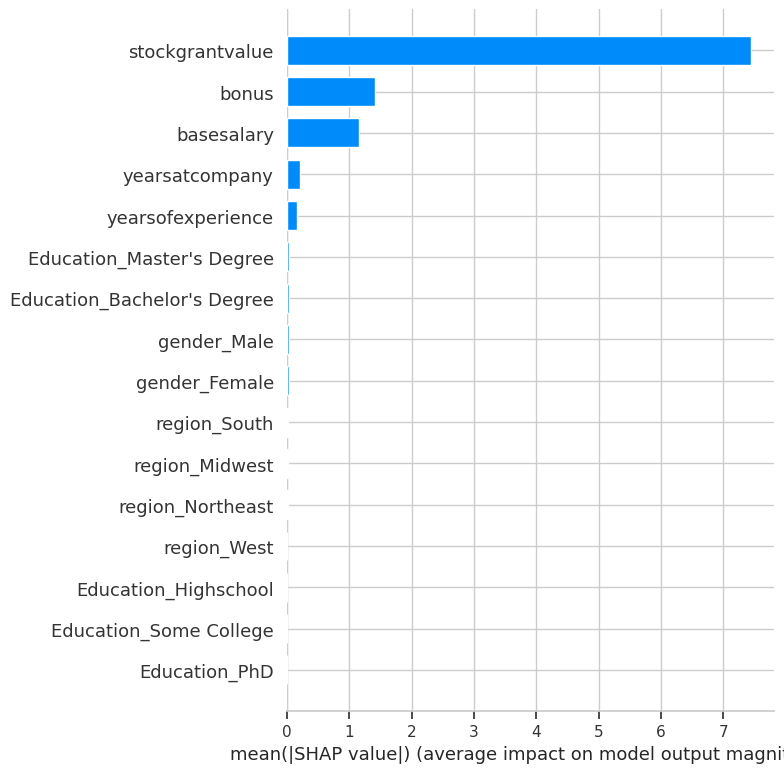

In [ ]:
# SHAP
logistic_model = pipeline.named_steps["logistic_regression"]
explainer_shap_lr = shap.LinearExplainer(logistic_model, X_train)
shap_values_lr = explainer_shap_lr.shap_values(X_test)
shap.summary_plot(shap_values_lr, X_test, plot_type="bar")

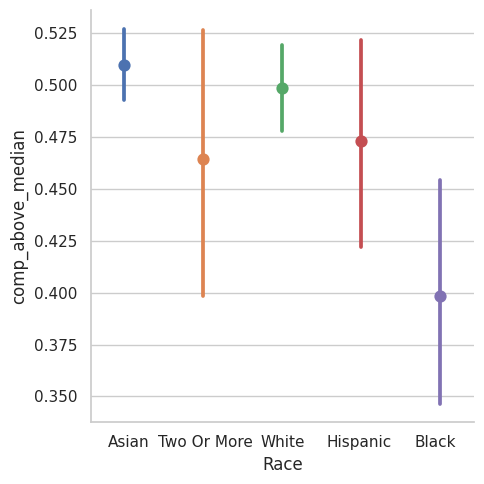

In [ ]:
# discrepancy analysis by racial groups

sns.catplot(y="comp_above_median", x="Race", hue="Race", data=data_2020,
            kind="point", dodge=True, errorbar=('ci', 95), linestyle='none');

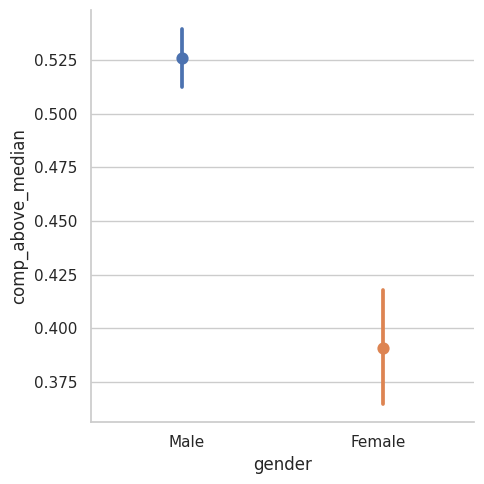

In [ ]:
# discrepancy analysis by gender

sns.catplot(y="comp_above_median", x="gender", hue="gender", data=data_2020,
            kind="point", dodge=True, errorbar=('ci', 95), linestyle='none');

In [ ]:
# false positive analysis by racial groups
mf1 = MetricFrame(metrics=false_negative_rate,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['Race'])

mf1.by_group

Race
Asian         0.09
Black         0.04
Hispanic      0.10
Two Or More   0.10
White         0.07
Name: false_negative_rate, dtype: float64

# Dataset Drift

In [ ]:
df_current = data_2021.dropna().copy()

for column in ['totalyearlycompensation', 'basesalary', 'stockgrantvalue', 'bonus']:
    df_current[column] = np.log1p(df_current[column])

# Step 2: Create target variable for `data_2021`
median_compensation = df_current['totalyearlycompensation'].median()
df_current['comp_above_median'] = (df_current['totalyearlycompensation'] > median_compensation).astype(int)

# Step 3: Prepare feature matrices
X_current = pd.get_dummies(df_current.drop(columns=[
    "Race", "totalyearlycompensation", "comp_above_median", "year"
]), drop_first=False)

# Align columns between `X_current` and `X_train`
X_current = X_current.reindex(columns=X_train.columns, fill_value=0)

# Step 4: Add model predictions
X_current['prediction'] = pipeline.predict(X_current)

In [ ]:
reference = X_train.copy()
reference['prediction'] = pipeline.predict(X_train)

# Step 5: Convert categorical columns for Evidently compatibility
reference['comp_above_median'] = Y_train.astype('category')
current = X_current.copy()
current['comp_above_median'] = df_current['comp_above_median'].astype('category')

## Report

In [ ]:
report = Report(metrics=[
    DataDriftPreset(),
])

report.run(reference_data=reference, current_data=current)
report